# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096-iap17/blob/master/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.34409687118480314 
 0.17874359926497063 
 0.6615161366264564  
 0.9867300547093554  
 0.1546730302846211  
 0.030283385609927382
 0.9576832736021419  
 0.14470028106547117 
 0.8738360238683882  
 0.5696518358905407  
 0.9952671448597858  
 0.0672287856319016  
 0.8502230361378975  
 ⋮                   
 0.40791940490840384 
 0.997445353662642   
 0.07845327512148503 
 0.3697754248150604  
 0.6530977903893762  
 0.30740236321743364 
 0.6584903667669182  
 0.9944248700171476  
 0.10896124392105566 
 0.5945808734746656  
 0.7451610863141649  
 0.8692718456221751  

In [2]:
sum(a)   

5.0006896210776605e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [40]:
# ] add BenchmarkTools

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed BenchmarkTools ─ v0.4.2
  Updating `~/.julia/environments/v1.1/Project.toml`
  [6e4b80f9] + BenchmarkTools v0.4.2
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v0.4.2


In [41]:
using BenchmarkTools  

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1186


#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [42]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [43]:
c_sum(a)

5.0006896210776e6

In [44]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [45]:
≈  # alias for the `isapprox` function

isapprox (generic function with 8 methods)

In [46]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [47]:
c_bench = @benchmark c_sum($a) 

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.723 ms (0.00% GC)
  median time:      10.030 ms (0.00% GC)
  mean time:        10.119 ms (0.00% GC)
  maximum time:     16.311 ms (0.00% GC)
  --------------
  samples:          494
  evals/sample:     1

In [48]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 9.723077 msec


In [49]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 9.72308

In [50]:
# ] add Plots

 Resolving package versions...
 Installed Plots ─ v0.23.0
  Updating `~/.julia/environments/v1.1/Project.toml`
  [91a5bcdd] + Plots v0.23.0
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [d38c429a] + Contour v0.5.1
  [28b8d3ca] + GR v0.37.0
  [e1d29d7a] + Missings v0.4.0
  [77ba4419] + NaNMath v0.3.2
  [ccf2f8ad] + PlotThemes v0.3.0
  [995b91a9] + PlotUtils v0.5.5
  [91a5bcdd] + Plots v0.23.0
  [992d4aef] + Showoff v0.2.1
  [a2af1166] + SortingAlgorithms v0.3.1
  [2913bbd2] + StatsBase v0.27.0
  Building Plots → `~/.julia/packages/Plots/UQI78/deps/build.log`


In [51]:
using Plots
gr()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


Plots.GRBackend()

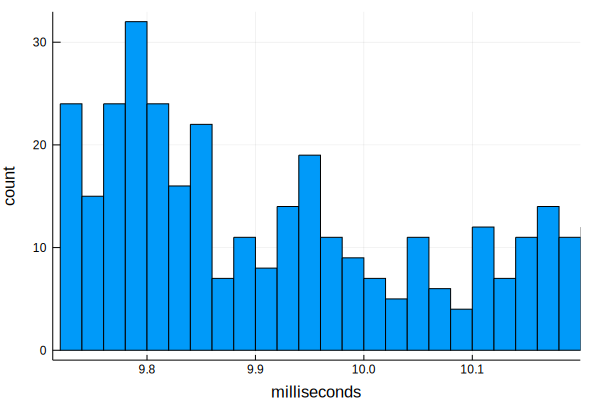

In [53]:
using Statistics
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [54]:
# ] add PyCall

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
  [438e738f] + PyCall v1.18.5
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [438e738f] + PyCall v1.18.5


In [55]:
using PyCall

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1186


In [56]:
# Call a low-level PyCall function to get a Python list, because
# by default PyCall will convert to a NumPy array instead (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [57]:
pysum(a)

5.0006896210776e6

In [58]:
pysum(a) ≈ sum(a)

true

In [59]:
py_list_bench = @benchmark $pysum($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     52.143 ms (0.00% GC)
  median time:      52.497 ms (0.00% GC)
  mean time:        54.813 ms (0.00% GC)
  maximum time:     100.324 ms (0.00% GC)
  --------------
  samples:          92
  evals/sample:     1

In [60]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "C"               => 9.72308
  "Python built-in" => 52.1429

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [61]:
# ] add Conda

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
  [8f4d0f93] + Conda v1.1.1
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [62]:
using Conda 
# Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/ranjan/.julia/packages/Conda/uQitS/src/Conda.jl:112


Solving environment: ...working... done


cryptography-2.4.2   | 575 KB    | ########## | 100% 
kealib-1.4.7         | 164 KB    | ########## | 100% 
libspatialite-4.3.0a | 3.0 MB    | ########## | 100% 
certifi-2018.11.29   | 145 KB    | ########## | 100% 
ca-certificates-2018 | 123 KB    | ########## | 100% 
libcurl-7.63.0       | 532 KB    | ########## | 100% 
rasterio-1.0.13      | 7.9 MB    | ########## | 100% 
python-3.7.2         | 21.6 MB   | ########## | 100% 
proj4-5.2.0          | 6.9 MB    | ########## | 100% 
libpq-11.1           | 2.6 MB    | ########## | 100% 
libnetcdf-4.6.1      | 1.2 MB    | ########## | 100% 
geos-3.7.1           | 1.5 MB    | ########## | 100% 
sqlite-3.26.0        | 2.3 MB    | ########## | 100% 
libgdal-2.3.3        | 16.5 MB   | ########## | 100% 
curl-7.63.0          | 138 KB    | ########## | 100% 
hdf5-1.10.4          | 4.5 MB    | ########## | 100% 
conda-4.6.1          | 1.7 MB    | #######7   |  78% 


## Package Plan ##

  environment location: /Users/ranjan/.julia/conda/3

  added / updated specs: 
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cryptography-2.4.2         |   py37ha12b0ac_0         575 KB
    kealib-1.4.7               |       hf5ed860_6         164 KB
    libspatialite-4.3.0a       |      h644ec7d_19         3.0 MB
    certifi-2018.11.29         |           py37_0         145 KB
    ca-certificates-2018.12.5  |                0         123 KB
    libcurl-7.63.0             |    h051b688_1000         532 KB
    rasterio-1.0.13            |   py37h9a122fd_0         7.9 MB
    python-3.7.2               |       haf84260_0        21.6 MB
    proj4-5.2.0                |       h0a44026_1         6.9 MB
    libpq-11.1                 |       h051b688_0         2.6 MB
    libnetcdf-4.6.1            |       hd5207e6_2         1.2 MB
    geos-3.7.1            

conda-4.6.1          | 1.7 MB    | ########## | 100% 

done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [64]:
numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) # converts to a numpy array by default

py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     5.033 ms (0.00% GC)
  median time:      5.562 ms (0.00% GC)
  mean time:        6.949 ms (0.00% GC)
  maximum time:     32.578 ms (0.00% GC)
  --------------
  samples:          718
  evals/sample:     1

In [65]:
numpy_sum(apy_list) # python thing

5.000689621077661e6

In [66]:
numpy_sum(apy_list) ≈ sum(a)

true

In [67]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 9.72308
  "Python numpy"    => 5.03313
  "Python built-in" => 52.1429

# 4. Python, hand-written 

In [68]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x11e1a67b8>

In [69]:
py_hand = @benchmark $sum_py($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  3
  --------------
  minimum time:     289.894 ms (0.00% GC)
  median time:      348.139 ms (0.00% GC)
  mean time:        353.459 ms (0.00% GC)
  maximum time:     470.565 ms (0.00% GC)
  --------------
  samples:          15
  evals/sample:     1

In [70]:
sum_py(apy_list)

5.0006896210776e6

In [71]:
sum_py(apy_list) ≈ sum(a)

true

In [72]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 9.72308
  "Python numpy"        => 5.03313
  "Python hand-written" => 289.894
  "Python built-in"     => 52.1429

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [73]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:648

In [74]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.875 ms (0.00% GC)
  median time:      4.939 ms (0.00% GC)
  mean time:        5.185 ms (0.00% GC)
  maximum time:     13.730 ms (0.00% GC)
  --------------
  samples:          962
  evals/sample:     1

In [75]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 9.72308
  "Python numpy"        => 5.03313
  "Python hand-written" => 289.894
  "Python built-in"     => 52.1429
  "Julia built-in"      => 4.87532

# 6. Julia (hand-written) 

In [76]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [77]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.742 ms (0.00% GC)
  median time:      10.111 ms (0.00% GC)
  mean time:        10.191 ms (0.00% GC)
  maximum time:     13.274 ms (0.00% GC)
  --------------
  samples:          490
  evals/sample:     1

In [79]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 9.72308
  "Python numpy"        => 5.03313
  "Julia hand-written"  => 9.74234
  "Python hand-written" => 289.894
  "Python built-in"     => 52.1429
  "Julia built-in"      => 4.87532

# Summary

In [82]:
for (key, value) in sort(collect(d))
    println(rpad(key, 20, "."), lpad(round(value, digits=1), 8, "."))
end

C........................9.7
Julia built-in...........4.9
Julia hand-written.......9.7
Python built-in.........52.1
Python hand-written....289.9
Python numpy.............5.0


In [84]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, digits=2), 10, "."))
end

Julia built-in............4.88
Python numpy..............5.03
C.........................9.72
Julia hand-written........9.74
Python built-in..........52.14
Python hand-written.....289.89
